# Active Learning for within TCR prediction of Mutational Epitopes

With active learning, we can reduce the amount of training data (=> also the wet-lab experiments) needed to train our classifier.

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm

In [3]:
import json
import os
import sys
sys.path.append('..')
from preprocessing import add_activation_thresholds, full_aa_features, get_aa_features 
from preprocessing import get_complete_dataset

from utils_al import train_classification_model, predict_classification_on_test, train_regression_model
from utils_al import predict_regression_on_test, evaluate_classification_models, evaluate_regression_models
from utils_al import get_aa_blosum, get_metrics_cls, get_metrics_reg

In [4]:
np.random.seed(42)

## Helper Functions

In [5]:
def blosum_distance(epitope_1, epitope_2):
    distance = 0
    blosum_mat = get_aa_blosum()
    for idx, (aa_1, aa_2) in enumerate(zip(epitope_1, epitope_2)):
        aa_distance = blosum_mat.loc[aa_1][aa_2]
        distance += aa_distance
    return distance

In [6]:
def uncertainty_from_regression(model, x_test):
    def get_individual_uncertainty(model, sample):
        uncertainty = np.std([tree.predict(sample) for tree in model.estimators_])
        return uncertainty    
    uncertainties = [get_individual_uncertainty(model, sample) for sample in x_test]
    return uncertainties

## Training set Initialisation

In [7]:
def init_blosum(base_epitope, all_apls):
    list_apls = [base_epitope]
    blosum_mat = get_aa_blosum()
    for idx, aa_base in enumerate(base_epitope):
        possible_aas = blosum_mat.loc[aa_base]
        aas_present = [aa for aa in possible_aas.index if 
                       base_epitope[:idx] + aa + base_epitope[idx+1:] in all_apls
                       and aa != aa_base]
        possible_aas = possible_aas[aas_present]
        if len(possible_aas) == 0:
            continue
        #print(possible_aas)
        new_aa = possible_aas.idxmin()
        new_epitope = base_epitope[:idx] + new_aa + base_epitope[idx+1:]
        list_apls.append(new_epitope)
    return list_apls


In [8]:
def init_random(base_epitope, all_apls):
    new_apls = list(np.random.choice(all_apls, replace=False, size=9))
    return new_apls

## Functions for data aquisition between iterations

In [9]:
def add_by_uncertainty_clf_avg(data_tcr, df_tcr, apls_train, clf, reg, N):
    p_test, _ = predict_classification_on_test(data_tcr, df_tcr, clf, apls_train)
    
    threshold = sum(p_test) / len(p_test)
    uncertainties = np.abs(p_test-threshold)
    idx_top_uncertain = uncertainties.argsort()[:N]

    apl_test = df_tcr[~df_tcr['epitope'].isin(apls_train)]['epitope']
    new_apls = apl_test.iloc[idx_top_uncertain].tolist()
    return new_apls

In [10]:
def add_by_random(data_tcr, df_tcr, apls_train, clf, reg, N):
    apl_test = df_tcr[~df_tcr['epitope'].isin(apls_train)]['epitope']
    new_apls = list(np.random.choice(apl_test, replace=False, size=N))
    return new_apls

Greedily add the APL the one that maximally increases the AUC in the next step. This can of course not been done in practice, since it uses knowledge that we do not have at this moment. Hovever, it serves as an upper bound, to what could be reached.

In [11]:
def add_gready_upper_bound(data_tcr, df_tcr, apls_train, clf, reg, N):
    new_apls = []
    for idx in range(N):
        max_score = 0.
        best_tcr = ''

        apls_test = df_tcr[~df_tcr['epitope'].isin(apls_train)]['epitope']
        def score_by_tcr(tcr):
            train_new = apls_train.copy()
            train_new = train_new + new_apls
            train_new.append(tcr)

            clf = train_classification_model(data_tcr, df_tcr, train_new, idx)
            p_test, c_truth = predict_classification_on_test(data_tcr, df_tcr, clf, train_new)
            score = metrics.roc_auc_score(c_truth, p_test)
            return score

        scores = {tcr: score_by_tcr(tcr) for tcr in apls_test}
        best_tcr = max(scores, key=scores.get)    
        new_apls.append(best_tcr)
    return new_apls 

## Training Loop

In [12]:
def run_learning_loop(data_tcr, df_tcr, metrics_reg, metrics_class, method_init, method_data_aquisition, 
                      N=8, M=5, base_epitope='SIINFEKL', seed=0):
    all_apls = df_tcr['epitope'].unique()
    apls_train = method_init(base_epitope, all_apls)

    results = {}
    for metric_name in list(metrics_class[0].keys()) + list(metrics_class[1].keys()) + list(metrics_reg.keys()):
        results[metric_name] = []
        
    for idx in range(M):    
        clf = train_classification_model(data_tcr, df_tcr, apls_train, seed)
        p_test, c_truth = predict_classification_on_test(data_tcr, df_tcr, clf, apls_train)
        if len(c_truth.unique()) > 1:
            evaluate_classification_models(c_truth, p_test, metrics_class, results, idx)
        
        reg = train_regression_model(data_tcr, df_tcr, apls_train, seed)
        y_test, y_truth = predict_regression_on_test(data_tcr, df_tcr, reg, apls_train)
        evaluate_regression_models(y_truth, y_test, metrics_reg, results, idx)
        
        if (idx+1) * N + 1 > len(base_epitope)*19+1:
            print('Not enough data left for next step')
            break
        apls_train += method_data_aquisition(data_tcr, df_tcr, apls_train, clf, reg, N)
    
    path_apls = f'../results/active_learning/within/{EPITOPE}_selectedAPLs_'
    path_apls += f'{method_data_aquisition.__name__}.csv'
    if not os.path.exists(path_apls):
        with open(path_apls, 'w') as f:
            f.write('seed,tcr,apls\n')

    with open(path_apls, 'a') as f:
        f.write(f'{seed},{df_tcr["tcr"].unique()[0]},{str(apls_train)}\n')
    return results

In [13]:
def run_gready_upper_bound(data_tcr, df_tcr, metrics_reg, metrics_class,
                           N=8, M=5, base_epitope='SIINFEKL', seed=0):
    all_apls = df_tcr['epitope'].unique()
    apls_train = add_gready_upper_bound(data_tcr, df_tcr, [base_epitope], None, None, 9)

    results = {}
    for metric_name in list(metrics_class[0].keys()) + list(metrics_class[1].keys()) + list(metrics_reg.keys()):
        results[metric_name] = []
        
    for idx in tqdm(range(M)):    
        clf = train_classification_model(data_tcr, df_tcr, apls_train, seed)
        p_test, c_truth = predict_classification_on_test(data_tcr, df_tcr, clf, apls_train)
        
        if len(c_truth.unique()) > 1:
            evaluate_classification_models(c_truth, p_test, metrics_class, results, idx) # todo
        
        reg = train_regression_model(data_tcr, df_tcr, apls_train, seed)
        y_test, y_truth = predict_regression_on_test(data_tcr, df_tcr, reg, apls_train)
        evaluate_regression_models(y_truth, y_test, metrics_reg, results, idx)
        
        if (idx+1) * N + 1 > len(base_epitope)*19+1:
            print('Not enough data left for next step')
            break
        apls_train += add_gready_upper_bound(data_tcr, df_tcr, apls_train, None, None, N)
    return results

## Evalutation

In [14]:
# EPITOPE = 'VPSVWRSSL'
EPITOPE = 'SIINFEKL'

if EPITOPE == 'SIINFEKL':
    #Settings
    NORMALIZATION = 'AS'
    THRESHOLD = '46.9'
else:
    NORMALIZATION = 'pc'
    THRESHOLD = '66.09'

### Load the data

In [15]:
data = get_complete_dataset(EPITOPE)
data = add_activation_thresholds(data, epitope=EPITOPE)
data.head()

,activation,tcr,mut_pos,mut_ami,orig_ami,epitope,cdr3a,cdr3b,cdr3a_aligned,cdr3b_aligned,wild_activation,residual,normalization,is_educated,threshold,is_activated
0,25.659542,ED5,0,A,S,AIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-54.070458,AS,True,15,True
1,12.799865,ED5,0,C,S,CIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-66.930135,AS,True,15,False
2,50.122836,ED5,0,D,S,DIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-29.607164,AS,True,15,True
3,78.234689,ED5,0,E,S,EIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-1.495311,AS,True,15,True
4,5.508727,ED5,0,F,S,FIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-74.221273,AS,True,15,False


In [16]:
print(f'Amount initial data: {len(data)}')
data = data[data['normalization'] == NORMALIZATION]
data = data[data['threshold'] == THRESHOLD]
if EPITOPE=='SIINFEKL':
    data = data[data['is_educated'] == True]
print(f'Amount reduced data: {len(data)}')

Amount initial data: 30753
Amount reduced data: 2448


### Embed the data

In [17]:
aa_features = get_aa_features()
features_no_mutation = aa_features.loc[['-']]
features_no_mutation.rename(index={'-': None}, inplace=True)
aa_features = pd.concat([aa_features, features_no_mutation])

In [18]:
sequence_representation = full_aa_features(data, aa_features[['factors']], base_peptide=EPITOPE)

### Run experiments for evaluation

In [19]:
def run_experiment(method_init, method_data_aquisition, metrics_reg, metrics_class, N, M):
    results = {}
    for metric_name in list(metrics_reg.keys()) + list(metrics_class[0].keys()) + list(metrics_class[1].keys()):
        results[metric_name] = []

    for i in tqdm(range(100)):
        for tcr in data['tcr'].unique():
            mask_tcr = data['tcr'] == tcr
            sequence_rep_tcr =  sequence_representation[mask_tcr]
            data_tcr = data[mask_tcr] 
        

            if sum(data_tcr['is_activated']) == 0 or sum(data_tcr['is_activated'] == len(data_tcr)):
                continue

            if method_data_aquisition == 'greedy':
                scores = run_gready_upper_bound(sequence_rep_tcr, data_tcr, 
                                                metrics_reg, metrics_class,
                                                N=N, M=M, seed=i)
            else:
                scores = run_learning_loop(sequence_rep_tcr, data_tcr, 
                                           metrics_reg, metrics_class, 
                                           method_init, method_data_aquisition, 
                                           N=N, M=M, seed=i, base_epitope=EPITOPE)

            tcr_info = [tcr, True]
            for name, score in scores.items():
                results[name] += [tcr_info + val for val in score]
            if method_data_aquisition == 'greedy':
                return results
    return results

Init Methods:
- init_blosum
- init_random

Aquisition Methods:
- add_by_uncertainty_clf 
- add_by_uncertainty_clf_avg
- add_by_random
- add_by_uncertainty_reg_sdt => todo 
- add_gready_upper_bound  => beware: very time intensive => todo


#### Define Metrics

In [20]:
metrics_reg = get_metrics_reg()
metrics_cls = get_metrics_cls()

#### Init methods

In [21]:
N = 8
M = 1

In [22]:
path_out = f'../results/active_learning/within/{EPITOPE}_FULL_init_blosum.json'

if not os.path.exists(path_out):
    results_init_blosum = run_experiment(init_blosum, add_by_random,
                                     metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_init_blosum, json_file)
else:
    with open(path_out) as f:
        results_init_blosum = json.load(f) 

 10%|████████                                                                         | 10/100 [01:09<10:15,  6.84s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 16%|████████████▉                                                                    | 16/100 [01:50<09:37,  6.88s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|████████████████████▎                                                            | 25/100 [02:53<08:42,  6.96s/it]C:\Users\

In [23]:
path_out = f'../results/active_learning/within/{EPITOPE}_FULL_init_random.json'

if not os.path.exists(path_out):
    results_init_random = results_init_random = run_experiment(init_random, add_by_random,
                                     metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_init_random, json_file)
else:
    with open(path_out) as f:
        results_init_random = json.load(f) 

  1%|▊                                                                                 | 1/100 [00:07<11:51,  7.19s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|█▋                                                                                | 2/100 [00:14<11:52,  7.27s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|███▎                                                                              | 4/100 [00:28<11:34,  7.23s/it]C:\Users\

 51%|█████████████████████████████████████████▎                                       | 51/100 [05:47<05:32,  6.78s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 52%|██████████████████████████████████████████                                       | 52/100 [05:54<05:24,  6.77s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 54%|███████████████████████████████████████████▋                                     | 54/100 [06:07<05:10,  6.74s/it]C:\Users\

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [10:48<00:26,  6.67s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [10:55<00:20,  6.67s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [11:02<00:13,  6.66s/it]C:\Users\

In [24]:
summary_init = {
    'blosum': results_init_blosum,
    'random': results_init_random,
}

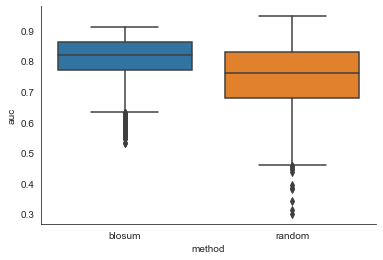

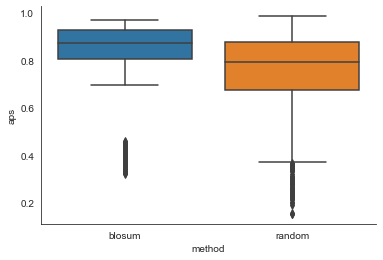

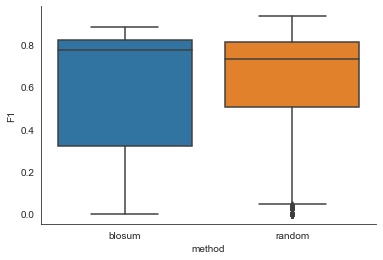

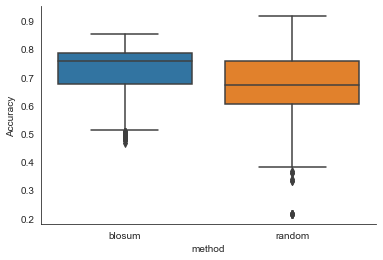

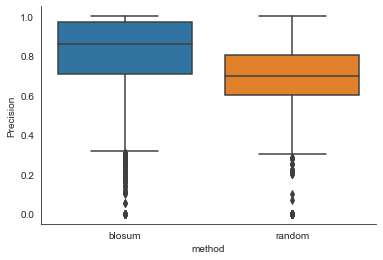

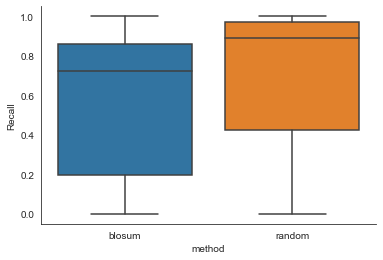

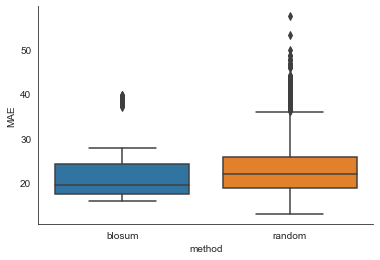

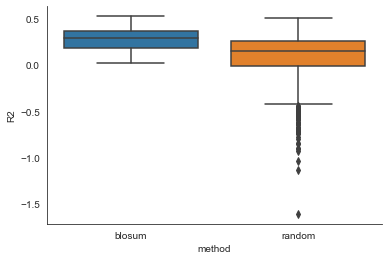

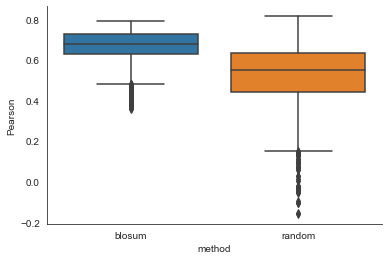

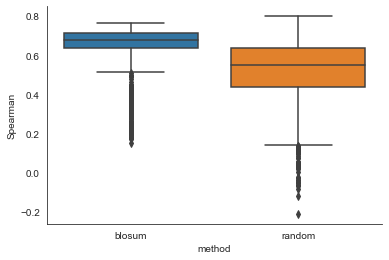

In [25]:
sns.set_style('white')
for name in list(list(metrics_cls[0].keys()) + list(metrics_cls[1].keys()) + list(metrics_reg.keys())):
    dfs_results = []
    for method in summary_init.keys():
        df = pd.DataFrame(summary_init[method][name])
        df.columns = ['tcr', 'is_educated', 'iteration', name]
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    plot = sns.boxplot(data=df_joint, x='method', y=name)
    sns.despine(bottom=False, left=False)
    plot.figure.savefig(f'../figures/active_learning/{EPITOPE}_init_{name}_N-{N}_FULL.png', dpi=300)
    plt.show()

#### Full loop

In [26]:
N = 8
M = 10

In [27]:
path_out = f'../results/active_learning/within/{EPITOPE}_FULL_act_avg_{N}.json'

if not os.path.exists(path_out):
    results_act_avg = run_experiment(init_blosum, add_by_uncertainty_clf_avg,
                             metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_act_avg, json_file)
else:
    with open(path_out) as f:
        results_act_avg = json.load(f) 

  1%|▊                                                                               | 1/100 [01:16<2:06:51, 76.88s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|██▍                                                                             | 3/100 [03:53<2:05:45, 77.79s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|█████▌                                                                          | 7/100 [09:02<1:59:55, 77.37s/it]C:\Users\

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 26%|████████████████████▌                                                          | 26/100 [33:33<1:35:30, 77.44s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control 

 48%|████████████████████████████████████▉                                        | 48/100 [1:01:50<1:06:54, 77.20s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 52%|████████████████████████████████████████                                     | 52/100 [1:07:02<1:02:07, 77.66s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 53%|████████████████████████████████████████▊                                    | 53/100 [1:08:20<1:00:45, 77.57s/it]C:\Users\

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 74%|█████████████████████████████████████████████████████████▋                    | 74/100 [1:39:25<43:44, 100.93s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control 

In [28]:
path_out = f'../results/active_learning/within/{EPITOPE}_FULL_rdm_{N}.json'

if not os.path.exists(path_out):
    results_rdm = run_experiment(init_random, add_by_random,
                                     metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_rdm, json_file)
else:
    with open(path_out) as f:
        results_rdm = json.load(f) 

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                               | 1/100 [01:13<2:01:45, 73.80s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|███▏                                                                            | 4/100 [04:55<1:58:33, 74.10s/it]C:\Users\

 32%|█████████████████████████▎                                                     | 32/100 [39:26<1:23:49, 73.97s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 36%|████████████████████████████▍                                                  | 36/100 [44:21<1:18:49, 73.89s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarnin

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 60%|███████████████████████████████████████████████▍                               | 60/100 [1:13:56<49:12, 73.82s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control 

 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:43:31<19:45, 74.09s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:48:27<14:47, 73.93s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:58:20<04:56, 74.04s/it]C:\Users\

The following results are created using the script "greedy_baseline_within_tcr.py" run for 50 times with different starting values to speed up the run.

In [29]:
import json
import os

def read_greedy_bound():
    path_in = f'../results/active_learning/within/greedy/{EPITOPE}/'
    res_files = [path_in + f for f in os.listdir(path_in) if os.path.isfile(os.path.join(path_in, f))]

    results_upper = {}
    for name in list(metrics_reg.keys()) + list(metrics_cls[0].keys()) + list(metrics_cls[1].keys()):
        results_upper[name] = []

    for path_file in res_files:

        with open(path_file) as f:
            res_tmp = json.load(f)
        for mtc, vals in res_tmp.items():
            vals = [el[:1] + [True] + el[1:] for el in vals]
            results_upper[mtc] += vals
    return results_upper
#results_upper = read_greedy_bound()

In [32]:
summary_8 = {
    'active_avg': results_act_avg,
    'random': results_rdm,
    #'upper bound': read_greedy_bound(),
}

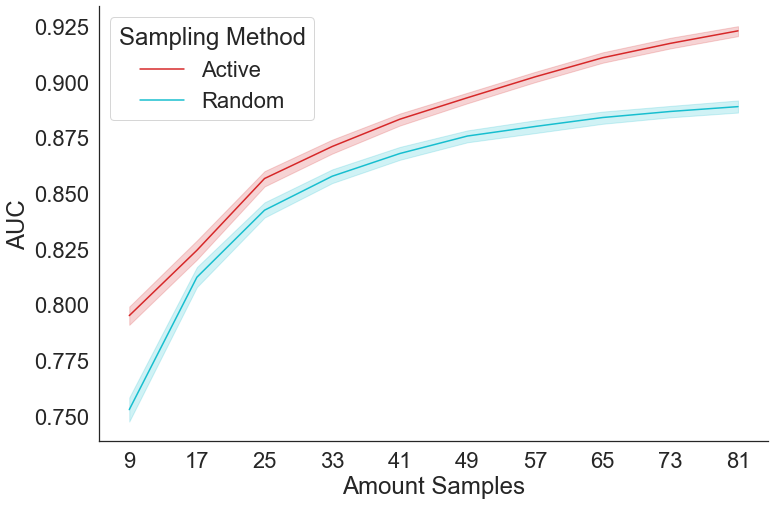

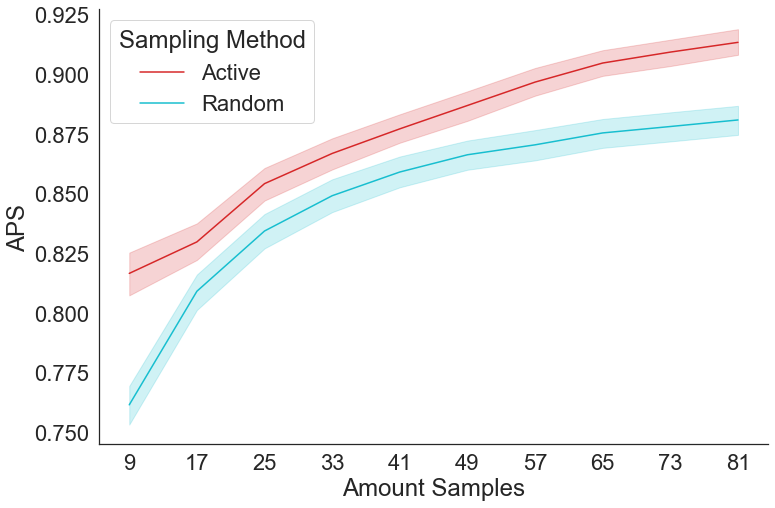

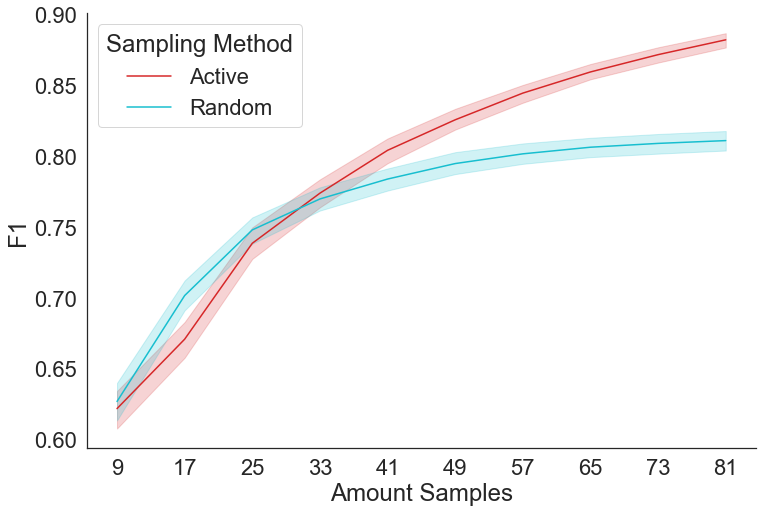

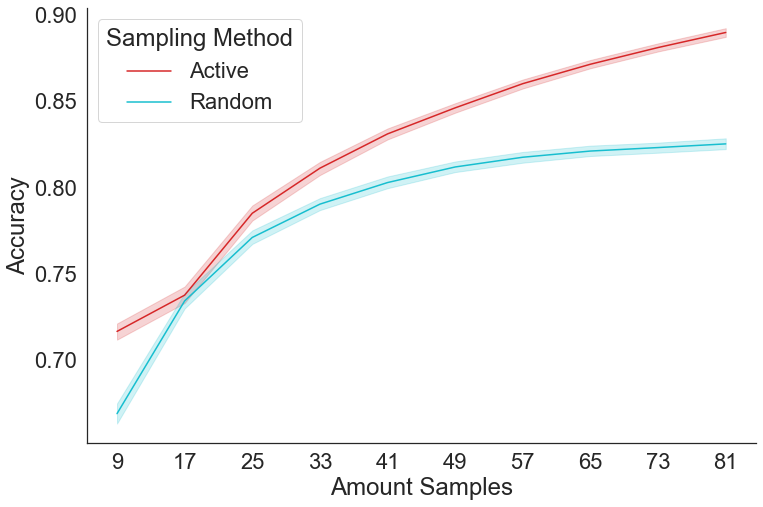

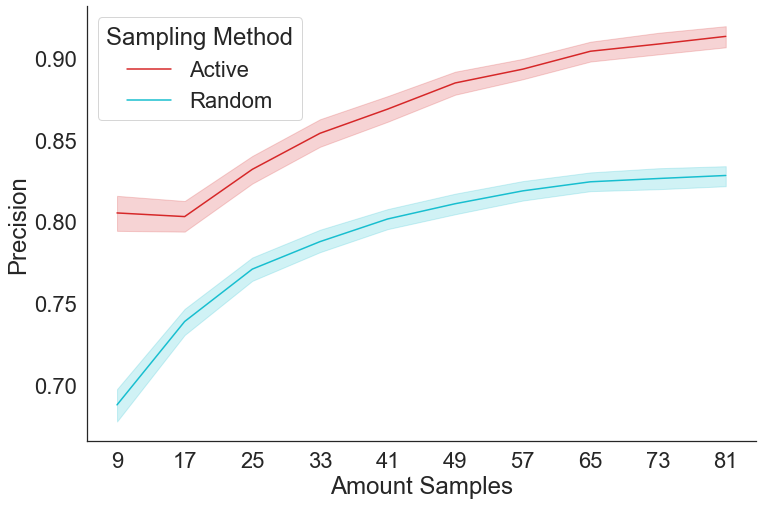

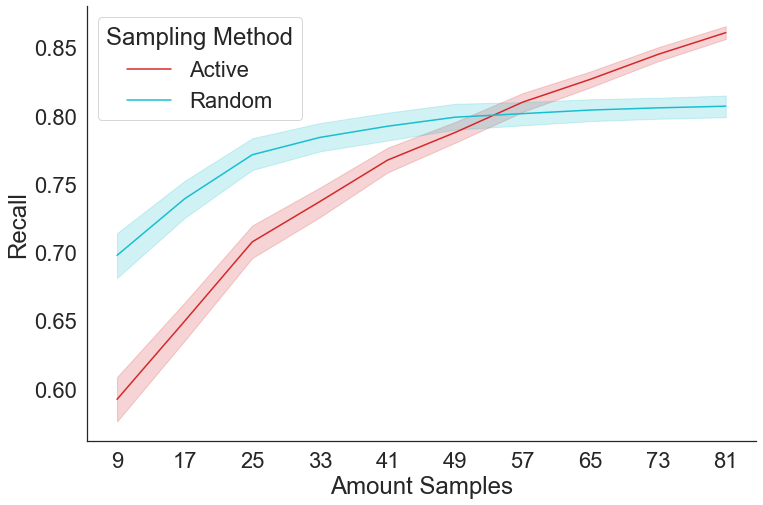

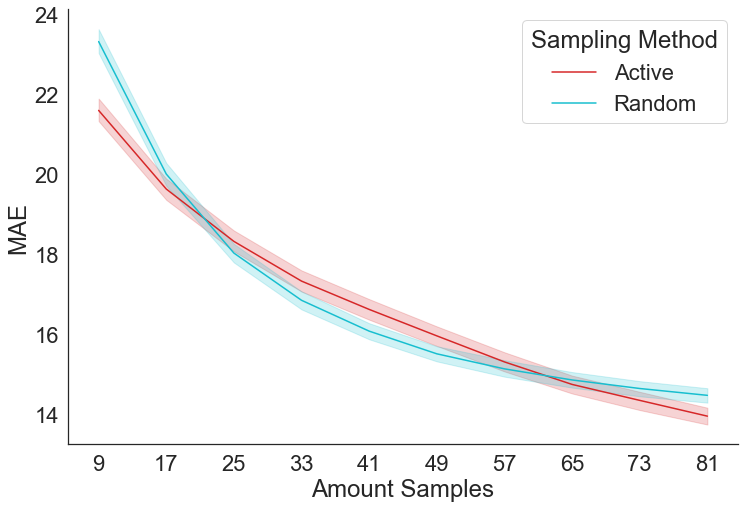

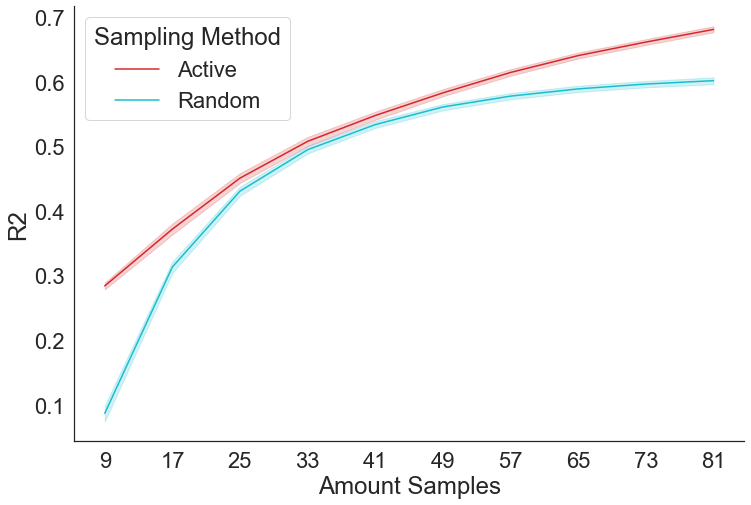

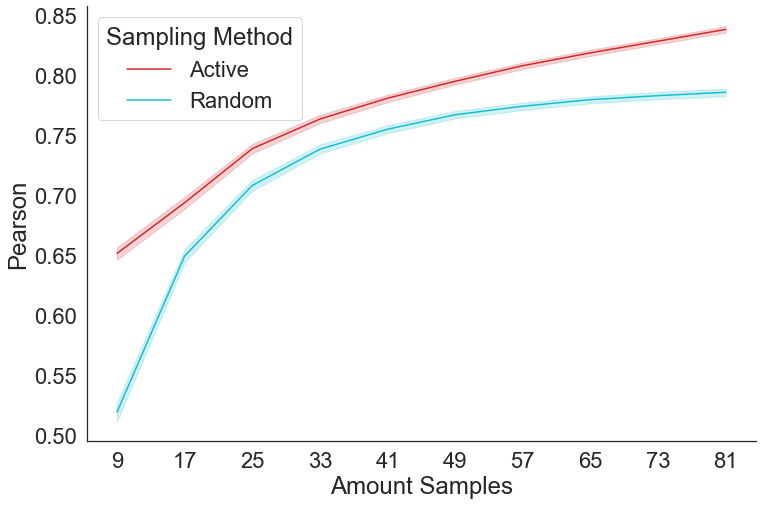

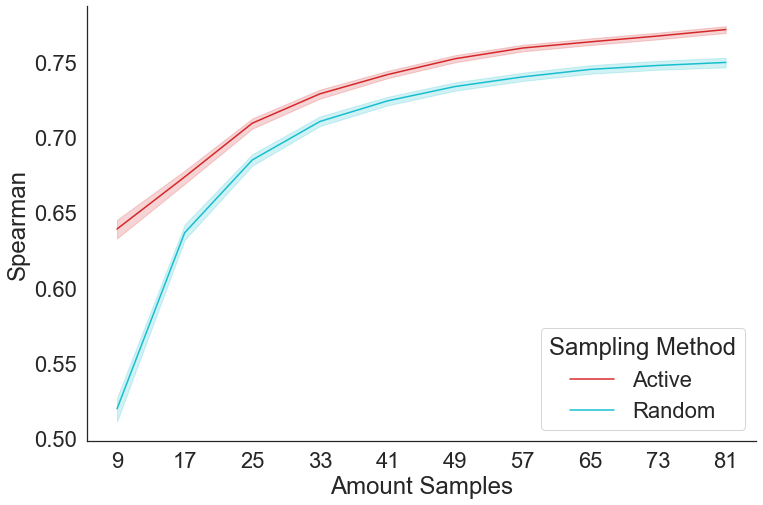

In [33]:
sns.set(font_scale=2)
sns.set_style('white')

palette = {'active_avg': 'tab:red', 'upper bound': 'tab:olive', 'random': 'tab:cyan'}

for name in list(list(metrics_cls[0].keys()) + list(metrics_cls[1].keys()) + list(metrics_reg.keys())):
    plt.figure(figsize=(12, 8))
    dfs_results = []
    for method in summary_8.keys():
        df = pd.DataFrame(summary_8[method][name])
        df.columns = ['tcr', 'is_educated', 'iteration', name]
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    plot = sns.lineplot(data=df_joint, x='iteration', y=name, hue='method', palette=palette)
    sns.despine(bottom=False, left=False)
    
    plot.set(xlabel='Amount Samples')
    if len(name)<=3:
        plot.set(ylabel=name.upper())
        
    plt.legend(title='Sampling Method', labels=['Active', 'Random'])
    x_ticks = list(range(0, M))
    x_labels = ['9'] + [str(9+(i+1)*N) for i in range(M-1)]
    plot.set_xticks(x_ticks)
    plot.set_xticklabels(x_labels)
    plot.figure.savefig(f'../figures/active_learning/{EPITOPE}_active_within_class_{name}_N-{N}_FULL.png', dpi=300)
    plot.figure.savefig(f'../figures/active_learning/{EPITOPE}_active_within_class_{name}_N-{N}_FULL.pdf', dpi=300)
    plt.show()